In [1]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# 'Year','CRSDepTime','ArrTime','CRSArrTime','CRSElapsedTime'

In [3]:
def load_data():
    cols_91 = ['Month','DayofMonth','DayOfWeek','DepTime','UniqueCarrier','FlightNum','ActualElapsedTime','ArrDelay','DepDelay','Origin','Dest','Distance','Cancelled','Diverted']
    cols_01 = ['Month','DayofMonth','DayOfWeek','DepTime','UniqueCarrier','FlightNum','TailNum','ActualElapsedTime','ArrDelay','DepDelay','Origin','Dest','Distance','TaxiIn','TaxiOut','Cancelled','Diverted']
    return pd.read_csv("Data/1991.csv.gz", encoding='cp1252', compression="gzip", usecols=cols_91), pd.read_csv("Data/2001.csv.gz", encoding='cp1252', compression="gzip", usecols=cols_01)

In [4]:
df91, df01 = load_data()

In [5]:
df91.sample(100).to_csv('Data/sdf91.csv', index=False)
df01.sample(100).to_csv('Data/sdf01.csv', index=False)

In [6]:
def process_and_save_data(df, categorical_cols, numerical_cols, filename):
    # Handling missing values
    df = df.dropna().reset_index()  # Dropping rows with missing values or use df.fillna() to impute missing values

    df['OnTime'] = df['ArrDelay'].apply(lambda x: 1 if x <= 0 else 0)

    # Separate features and the modified target variable
    X = df.drop(columns=['ArrDelay', 'OnTime'])  # Features
    y = df['OnTime']  # Target variable

    # Handle missing values in the numerical columns (if any)
    imputer = SimpleImputer(strategy='mean')
    X[numerical_cols] = imputer.fit_transform(X[numerical_cols])

    # Scale numerical columns
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    # Apply Label Encoding to categorical columns
    encoder = LabelEncoder()
    X_encoded = X[categorical_cols].apply(encoder.fit_transform)

    # Combine encoded and non-categorical columns
    X_processed = pd.concat([X_encoded.reset_index(drop=True), X[numerical_cols].reset_index(drop=True)], axis=1)

    # Combine X_processed and y into a single DataFrame
    combined_df = pd.concat([X_processed, y], axis=1)

    # Save the combined DataFrame to a CSV file
    combined_df.sample(100).to_csv(filename, index=False)

    return combined_df

In [7]:
pdf91 = process_and_save_data(df91, ['UniqueCarrier', 'Origin', 'Dest'],['Month','DayofMonth','DayOfWeek','DepTime','FlightNum','ActualElapsedTime','DepDelay','Distance','Cancelled','Diverted'], 'pdf91.csv')

In [8]:
pdf01 = process_and_save_data(df01, ['UniqueCarrier','TailNum' ,'Origin', 'Dest'],['Month','DayofMonth','DayOfWeek','DepTime','FlightNum','ActualElapsedTime','DepDelay','Distance','TaxiIn','TaxiOut','Cancelled','Diverted'], 'pdf01.csv')

In [9]:
pdf91 = pdf91.dropna()
pdf01 = pdf01.dropna()

In [12]:
def train_decision_tree_classifier(processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features
    y = processed_df['OnTime']  # Target variable

    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Training the Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Predict on the test set and calculate accuracy
    y_pred = dt_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return dt_classifier, accuracy


In [ ]:
def train_xgboost(processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features
    y = processed_df['OnTime']  # Target variable

    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Training the XGBoost Classifier model
    xgb_clf = XGBClassifier(random_state=42)
    xgb_clf.fit(X_train, y_train)

    # Predict on the test set and calculate accuracy
    y_pred = xgb_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return xgb_clf, accuracy

In [14]:
dt91, a_dt91 = train_decision_tree_classifier(pdf91)
print("Accuracy:", a_dt91)

Accuracy: 0.9103674570896325


In [15]:
xgb91, a_xgb91 = train_xgboost(pdf91)
print("Accuracy:", a_xgb91)

Accuracy: 0.859892032140108


In [16]:
def analyze_lr_features(trained_model, processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features

    # Extracting feature importance (using absolute coefficients)
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(trained_model.coef_[0])
    })

    # Sorting features by importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Displaying the most important features
    return feature_importance


In [17]:
def analyze_dt_features(trained_model, processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features

    # Extracting feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': trained_model.feature_importances_
    })

    # Sorting features by importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    return feature_importance


In [18]:
def analyze_xgb_features(trained_model, processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features

    # Extracting feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': trained_model.feature_importances_
    })

    # Sorting features by importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    return feature_importance


In [20]:
dt_feature_importance_91 = analyze_dt_features(dt91, pdf91)

In [21]:
xgb_feature_importance_91 = analyze_xgb_features(xgb91, pdf91)

In [22]:
def plot_model_accuracy(accuracies):
    models = ['Decision Tree', 'XGBoost']
    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'green'])
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)  # Set the y-axis limit to match accuracy values (0-1)
    plt.show()

In [23]:
def combine_feature_importance_dfs(dt_feature_importance, xgb_feature_importance):
    dt_feature_importance['Model'] = 'Decision Tree'
    xgb_feature_importance['Model'] = 'XGBoost'
    
    combined_df = pd.concat([dt_feature_importance, xgb_feature_importance], ignore_index=True)
    return combined_df

In [24]:
def plot_feature_importance(combined_feature_importance):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Feature', y='Importance', hue='Model', data=combined_feature_importance, palette='viridis')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance Comparison')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.tight_layout()
    plt.show()


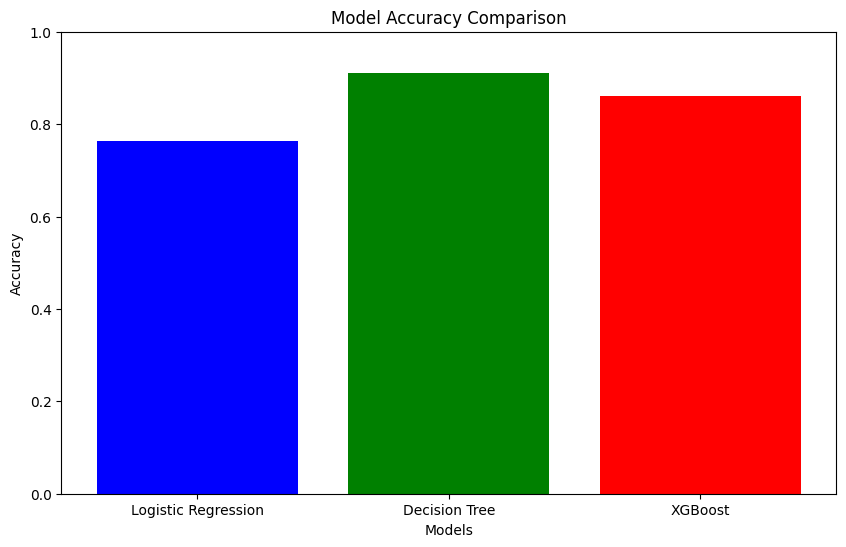

In [25]:
plot_model_accuracy([a_dt91,a_xgb91])

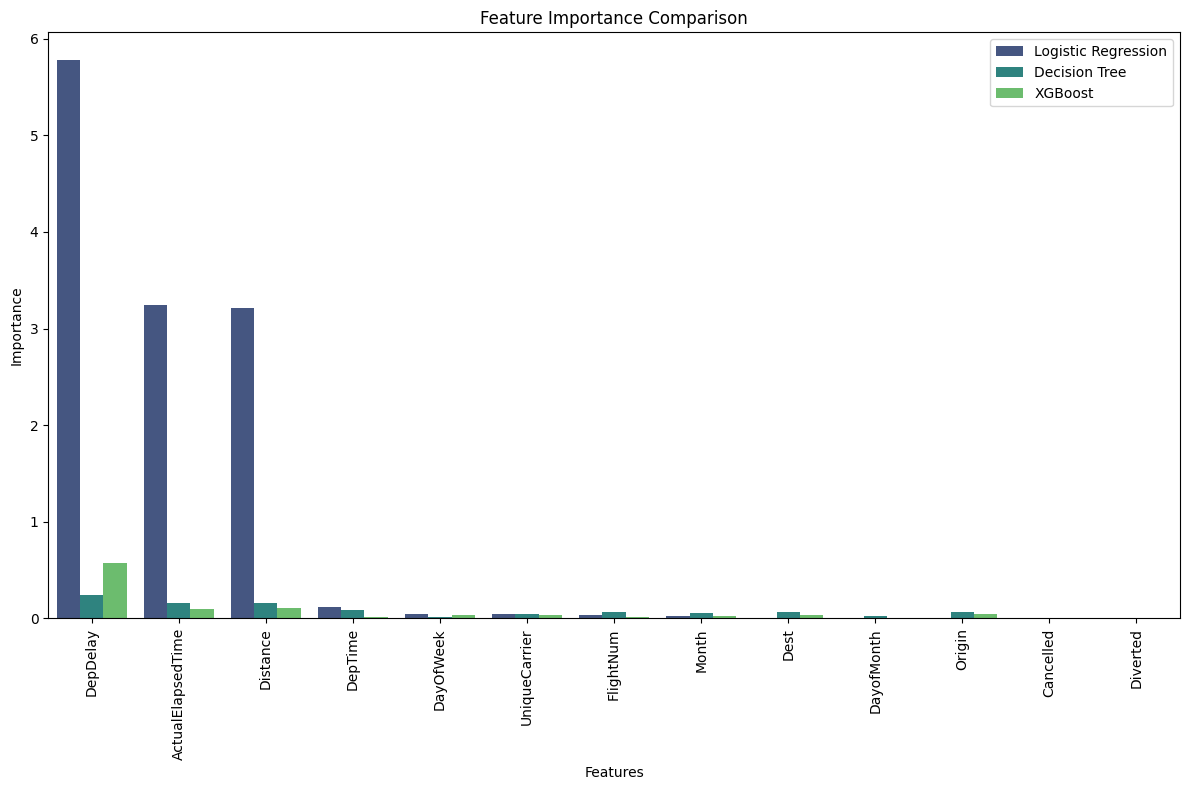

In [26]:
combined_feature_importance = combine_feature_importance_dfs(dt_feature_importance_91, xgb_feature_importance_91)

plot_feature_importance(combined_feature_importance)

In [27]:
combined_feature_importance.to_csv('features_importance.csv')

In [28]:
combined_feature_importance

,Feature,Importance,Model
0,DepDelay,5.777509,Logistic Regression
1,ActualElapsedTime,3.245403,Logistic Regression
2,Distance,3.211156,Logistic Regression
3,DepTime,0.118943,Logistic Regression
4,DayOfWeek,0.049325,Logistic Regression
5,UniqueCarrier,0.041940,Logistic Regression
6,FlightNum,0.034891,Logistic Regression
7,Month,0.028725,Logistic Regression
8,Dest,0.002538,Logistic Regression
9,DayofMonth,0.002317,Logistic Regression
